# **AM 207**: Homework 6

_ _ _ _ _

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
Handed out: Thursday, March 12th, 2015<br>
Due: 11.59 P.M. Friday March 28th, 2015

**Instructions**:

+ Upload your answers in an ipython notebook to the dropbox on iSites, you can find the link on our homepage (http://am207.org/).

+ We will provide you imports for your ipython notebook. For the first part of this course, please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_LASTNAME_FIRSTNAME_HW6.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_LASTNAME_FIRSTNAME_HW0.tar.gz or AM207_LASTNAME_FIRSTNAME_HW0.zip

+ Please remember that your solution should be a **report**! We would like some explanations of your ideas, and ways to approach the solution. Also please comment your code. 

+ THERE WILL BE NO LATE DAYS FOR THIS HW! 

### Have Fun!
_ _ _ _ _
_ _ _ _ _

In [3]:
# Do NOT Add to this list without prior approval

import time
import math
import numpy as np
import pandas as pd
import scipy
from statsmodels.graphics.gofplots import qqplot_2samples


# for pure convenience
from scipy.stats import norm


%matplotlib inline
import matplotlib.pyplot as plt

# you don't have to use seaborn if you prefer plain matplotlib
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')

### Question 1:  The Best Thing Since Sliced Sampling

Let's understand slice sampling by seeing some of the quirks.  
(a) Below you'll find a bad slice sampler named bad_slice_sampler.  Show that it works perfectly for unimodal distributions (guassians, cauchy, etc..).  How do you compare to the true distribution?  * **Hint:  You can get your distribution from scipy.stats and then use scipy.stats.probplot.  You can also plot the normed histogram.** * 

(b) Show that it doesn't work as well on multimodal distributions.  One suggestion is the gaussian mixture from lecture which we've defined below as the function ex2.  Draw 5000 samples and with ex2 I suggest a width of 0.2, but experiment with widths.  How does width affect sampling performance? 

(c) Fix bad_slice_sampler to get a correct univariate slice sampling implementation.  Call it good_slice_sampler and use the function skeleton we give you below. What needs to be changed and why does that affect sampling performance?  Draw true samples for the mixture distribution (how might you sample from a mixture distribution) and compare to both you sampling implementations.  * **Hint: if you have statsmodels installed, you can use qqplot_2samples to create a qqplot based on samples.  What should that look like?  What does it look like for bad_slice sampler? ** *

(d) * **Challenge -- Optional, but without this you won't be able to get a 5 on this HW** *: Implement a 2 dimensional slice sampler using the hyper-rectangle method.  Use the function skeleton given below. Implement (using the function skeleton given below) a 2 dimensional metropolis-hastings sampler.  How do the two compare with respect to speed, effective sample sizes, autocorrelation, and traceplots on the following form of a Banana PDF from HW4 (use a sample size of 10000 samples):

$ p(X) \propto {\rm exp} \left[ - \frac{1}{2a^2} \left(\sqrt{x_1^2 + x_2^2} -1 \right)^2 -  \frac{1}{2b^2} \left(x_2  - 1 \right)^2  \right] $ where $a=0.1$ and $b=1$.

In [4]:
mu1=3; mu2=10; sigma1=1; sigma2=2; l1=.30; l2=.70;
ex = lambda x: 0.5*norm.pdf(x,loc=-1,scale=0.3)+ 0.5*norm.pdf(x,loc=1,scale=0.3)
ex2 = lambda x: l1*norm.pdf(x, mu1, sigma1)+l2*norm.pdf(x, mu2, sigma2)

def bad_slice_sampler(pdf, x0, width, division=0.5, sample_size=5000, burnin=0, thin=0):

    # initialize the sampler
    y0 = np.random.uniform(low=0,high=pdf(x0))
    samples = []

    # create an interval around the original point
    #init_unif = np.random.uniform(low=0,high=width)
    left = x0 - division*width
    right = left + width

    # slice sampling magic
    for i in range(sample_size + burnin):

        # select our interval
        while(y0 < pdf(left)): # left endpoint
            left = left - width

        while (y0 < pdf(right)): # right endpoint
            right = right + width

        while (True):
            # new proposal
            xstar  = np.random.uniform(low=left, high=right)

            # loop until we find the point inside the region
            if y0 < pdf(xstar):
                break
            else:
                # shrink interval
                if xstar < x0:
                    left = xstar
                if xstar > x0:
                    right = xstar

        # save the current sample
        samples.append(xstar)

        # the last sample is now the proposal
        x0 = xstar

        # get the new y0 for next step
        y0 = np.random.uniform(low=0, high=pdf(x0))

        # reset the interval around x0
        #init_unif = np.random.uniform(low=0,high=width)
        left = x0 - division*width
        right = left + width


    return np.array(samples[burnin:])

def good_slice_sampler(pdf, x0, width, sample_size=5000, burnin=0, thin=0):

    # initialize the sampler
    y0 = np.random.uniform(low=0,high=pdf(x0))
    samples = []

    # create an interval around the original point
    # the interval should be randomly placed around the point
    #init_unif = np.random.uniform(low=0,high=width)
    division = np.random.uniform()
    left = x0 - division*width
    right = left + width

    # slice sampling magic
    for i in range(sample_size + burnin):

        # select our interval
        while(y0 < pdf(left)): # left endpoint
            left = left - width

        while (y0 < pdf(right)): # right endpoint
            right = right + width

        count = 0
        while (True):
            # new proposal
            xstar  = np.random.uniform(low=left, high=right)
            count += 1
            #if count %10000 == 0:
                #print xstar, pdf(xstar)
            # loop until we find the point inside the region
            if y0 < pdf(xstar):
                break
            else:
                # shrink interval
                if xstar < x0:
                    left = xstar
                if xstar > x0:
                    right = xstar

        # save the current sample
        samples.append(xstar)

        # the last sample is now the proposal
        x0 = xstar

        # get the new y0 for next step
        y0 = np.random.uniform(low=0, high=pdf(x0))

        # reset the interval around x0
        # the interval should be randomly placed around the point
        #init_unif = np.random.uniform(low=0,high=width)
        division = np.random.uniform()
        left = x0 - division*width
        right = left + width


    return np.array(samples[burnin:])

def metropolis_hastings_sampler(pdf,x0,sample_size=5000,burnin=0, thin=0):
    
    ## Metropolis Hastings here
    pass

def slice_sampler_2d(pdf, x0, width, sample_size=5000, burnin=0, thin=0):
    
    ## Implement 2d slice sampler here
    ## see lecture 11 notes for a head start
    pass

#### Q1(a) Bad Sampler for Gaussian Dist.

In [5]:
gaussian = lambda x: norm.pdf(x, loc=1, scale=1)
samples = bad_slice_sampler(gaussian, 0, 0.5)

((array([-2.63568806, -2.40036853, -2.27067228, ...,  4.27067228,
          4.40036853,  4.63568806]),
  array([-3.15813507, -2.46876656, -2.24512338, ...,  4.23455408,
          4.25715292,  4.26078385])),
 (1.0004622060598143, 0.0051585954868280659, 0.99984232347673851))

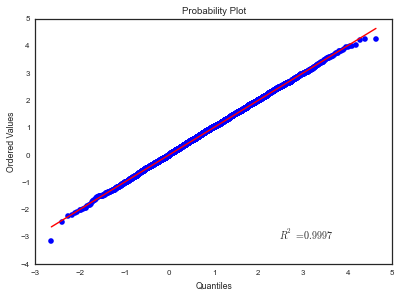

In [6]:
fig = plt.figure()
ax = plt.gca()
scipy.stats.probplot(samples,  dist=scipy.stats.norm, sparams=(1,1),plot=ax)

**1(a) Analysis**

From the QQ-plot, it can be seen that the quantiles of samples match well with the quantile of the normal distribution (the line is $y=x$). So the bad sampler can sample good samples from a normal distribution. In the plot, the quantile at the tail shows mismatch. Under current sample size, those points are very unlikely to be sampled, so their quantiles are sensensitive to randomness. Increasing the sample size will help get better QQ-plot.

**Note:** The burn-in is 0 because I choose a really good starting point to save computation time. The strategy is not applicable for complex distribution. 

#### 1(b) Bad Sampler for multimodal dist.

**Generate Data from Numpy**

In [18]:
#A point has 30% chance to be drawn from the first distribution
np_select = np.random.uniform(size = 5000)
#selects points that come from the first distribution
np_select = np_select<l1
np_samples = np.empty(5000)
#Draw samples from both distributions
np_sample1 = np.random.normal(mu1, sigma1, 5000)
np_sample2 = np.random.normal(mu2, sigma2, 5000)
np_samples[np_select] = np_sample1[np_select]
np_samples[~np_select] = np_sample2[~np_select]
#np_samples = np.array(list(np.random.normal(mu1, sigma1, 5000*l1)) + list(np.random.normal(mu2, sigma2, 5000*l2)))

In [24]:
samples02 = bad_slice_sampler(ex2, 1, 0.2)

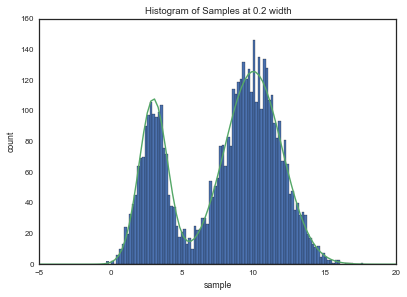

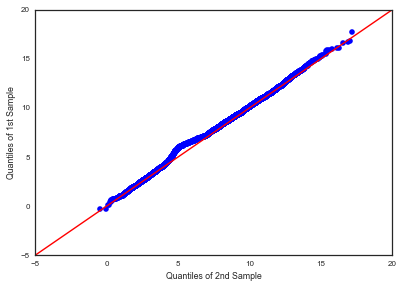

In [25]:
ex2_v = np.vectorize(ex2)
plt.hist(samples02, bins=100)
plt.xlim(-5,20)
bin_width = (max(samples02)-min(samples02))/100 #calculate bin width for normalizing
plt.plot(np.linspace(-5,20,100), ex2_v(np.linspace(-5,20,100))*len(samples02)*bin_width)
plt.title('Histogram of Samples at 0.2 width')
plt.xlabel('sample')
plt.ylabel('count')
ax = qqplot_2samples(samples02, np_samples, line='45')

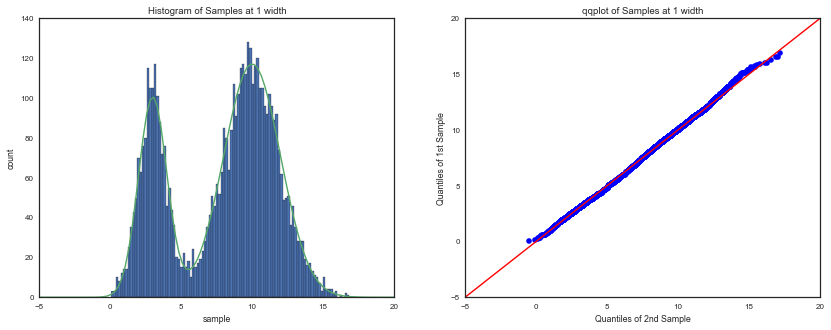

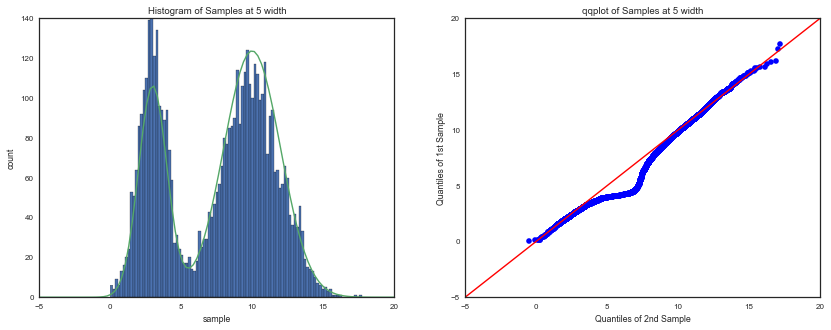

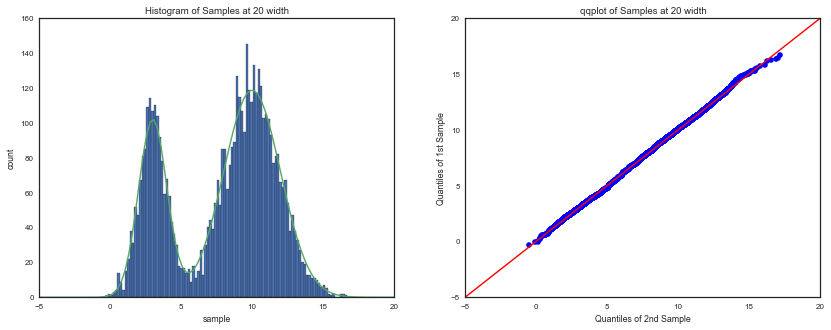

In [27]:
ws = [1, 5 , 20]
for w in ws:
    samples05 = bad_slice_sampler(ex2, 1, w)
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.hist(samples05, bins=100)
    plt.xlim(-5,20)
    bin_width = (max(samples05)-min(samples05))/100
    plt.plot(np.linspace(-5,20,100), ex2_v(np.linspace(-5,20,100))*len(samples05)*bin_width)
    plt.title('Histogram of Samples at '+str(w)+' width')
    plt.xlabel('sample')
    plt.ylabel('count')
    ax = plt.subplot(1,2,2)
    ax = qqplot_2samples(samples05, np_samples, line='45', ax = ax)
    plt.title('qqplot of Samples at '+str(w)+' width')
    _ = plt.show()

**1(b): Analysis**

The bad sampler is likely to get stuck in one region. So it will over-sample one mode and under sample the other. I run the sampler for several times, and sampler may over-sample the first or the second mode randomly. From the histogram and qq-plot, in this example, at width=0.2, the sampler over-samples one of the modes. 

I experimented with several widths. The one shown above has width=1, 5, 20. When we set width to 20, the bad sampler is working properly. Bigger width will enable the sampler to jump from one mode to the other easily, and avoid being stuck. This may explain the good property of the sampler at width=20. However, it seems that the sampler at width=5 performs consistently badly, and the sampler at width=1 performs consistently well. I am not sure about the reason behind this. 

#### 1(c) Good Slice Sampler

In [30]:
good_samples = good_slice_sampler(ex2, 0, 0.2)

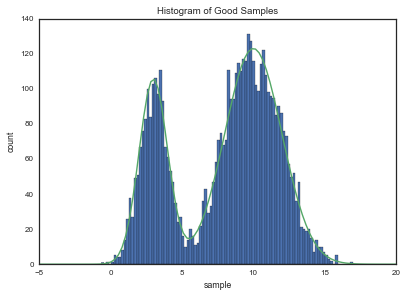

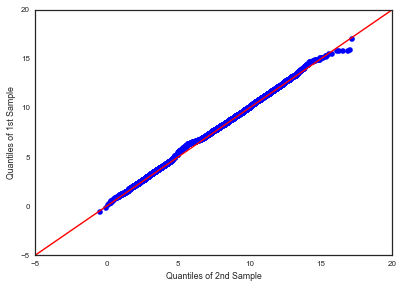

In [31]:
plt.hist(good_samples, bins=100)
plt.xlim(-5,20)
bin_width = (max(good_samples)-min(good_samples))/100
plt.plot(np.linspace(-5,20,100), ex2_v(np.linspace(-5,20,100))*len(good_samples)*bin_width)
plt.title('Histogram of Good Samples')
plt.xlabel('sample')
plt.ylabel('count')
ax = qqplot_2samples(good_samples, np_samples, line='45')

**1(c): Analysis**

From the qq-plot, it can be seen that with the same width, the good sampler works much better than the bad sampler. The change I make is to position width randomly around $x_0$ (draw a random division at each iteration). 

By sampling division at each iteration, I add a new source of randomness, and allow the sampler to move horizontally at a wider range. So it is less likely that the sampler will get stuck at one mode.

**Note: ** The width of the good sampler is chosen to be the same as the bad sampler. So their results are comparable.

### Question 2:  Hierarchical Modeling is No Victorian Secret

We have (from Bayesian Data Analysis, Gelman et. al.) a dataset of kidney cancer death rates by county in the US.  Let's assume that we can use a Poisson distribution to model the per county kidney death rate

$$ y_j \sim Poisson(n_j\theta_j) \\
 \theta_j \sim Gamma(\alpha, \beta)$$.

where $n_j$ is the total population of county j, $y_j$ is the number of kidney cancer deaths in county j and $\theta_j$ is the underlying death rate for county j.  A Poisson model makes sense because kidney cancer incidence should be a rare event (we hope!) and the Poisson is a good distribution for modeling rare events.  The gamma is a distribution with the right support that is conveniently the conjugate distribution for the Poisson. Before we were exposed to hierarchical modeling, we'd be inclined to use "full pooling" and choose one prior distribution for $\theta$ for all the counties.  Now that we have access to hierarchical modeling let's be a bit more sophisticated.  Let's define a hierarchical model where the $\alpha$ and $\beta$ are also drawn from gamma distributions as well.  Our full hierarchical model is defined below:
$$ y_j \sim Poisson(\lambda_j) \\
 \theta_j \sim Gamma(\alpha, \beta)\\
 \alpha \sim Gamma(a_{\alpha},b_{\alpha})\\
 \beta \sim Gamma(a_{\beta},b_{\beta})$$.


(a) Show that a Gamma is conjugate prior to a Poisson and write out the joint posterior density.

(b) Similar to what we did in lecture with the rat tumor and the beta binomial model, we can find full conditional distributions for $\lambda_j$, $\alpha$ and $\beta$.  Derive them.

(c) How might you choose your prior hyperparameters $\{a_{\alpha},\ b_{\alpha},\ a_{\beta},\ b_{\beta}\ \}$?

(d) You should have two conditional distributions that you need to sample from with MCMC (with some clever manipulations you may have just one) and one conditional distribution that you can sample from a Gamma.  Run a Gibbs sampler with the county data in <a href="HW6.csv">this file</a>.  (Feel free to use a subset of counties, e.g. the counties an individual state like Texas.  Only run the whole data set if you're in an ambitious "I'm at the top of the hiearchy" mood).  You'll want the columns death_count, population, and maybe (if you don't want to calculate it yourself) mortality_rate.  Use your good_slice_sampler (or as an alternative recycle a MH sampler from a previous HW) for drawing samples from the distributions that aren't from a known model.  Give posterior plots, posterior metrics and traceplots/other convergence criteria.  * ** Beware:  The gamma distribution in scipy.stat uses a different convention than we're used to.  It uses b as a scale parameter and you enter that parameter as the reciprocal of the normal scale parameter.  So, the pdf of $Gamma(a,b)$ in scipy would be scipy.stats.gamma.pdf(x, a, scale=1./b) ** *

One of the advantages of the Poisson Gamma hiearchical model in this case is that it acts almost like a regularizer for population disparities.  Counties with small populations will be highly influenced by the prior, whereas counties with high population (high data counts) will be influenced by the data. What kinds of suggestion do you have for improving the prior?

**1(a): Proof**

$$ \text{Gamma}(\alpha, \beta)\text{Pois}(\lambda) = \frac{\beta^\alpha}{\Gamma(\alpha)}\lambda^{\alpha-1}e^{-\beta\lambda}\frac{\lambda^y}{y!}e^{-\lambda} \\
\propto \lambda^{\alpha-1}e^{-\beta\lambda}\lambda^ye^{-\lambda} \\
\propto \lambda^{\alpha+y-1}e^{-(\beta+1)\lambda}\\
\propto \text{Gamma}(\alpha+y, \beta+1)$$.

The above proves that the product of Poisson distribution and Gamma distribution is Gamma distribution, so Gamma distribution is the conjugate prior of Poisson distribution.

If there are N data points, we can do the product one by one. The posterior distribution is: $$\text{Gamma}(\alpha+\sum_{i=i}^Ny_i, \beta+N)$$

**1(b): Conditional Distribution**

The posterior distribution
$$ P(\theta, \alpha, \beta|Y) \propto P(\alpha)P(\beta)\prod_{i=1}^NP(y_i|\theta, \alpha, \beta)\prod_{i=1}^NP(\theta_i|\alpha, \beta) \\
\propto P(\alpha)P(\beta)\prod_{i=1}^{N}\left\{\frac{\beta^\alpha}{\Gamma(\alpha)}\theta_i^{\alpha-1}e^{-\beta\theta_i}\frac{(n_i\theta_i)^{y_i}}{y_i!}e^{-n_i\theta_i}\right\}$$

To get the conditional distribution for $\theta_i$, we can treat $\alpha$ and $\beta$ in the posterior distribution as constants. According to the conjugate priors
$$ P(\theta_i|\alpha, \beta, Y) \propto \text{Gamma}(\alpha+y_i, \beta+n_i) $$

To get the conditional distribution for $\alpha$, we can remove all terms that are not related to $\alpha$ from the posterior distribution.
$$ P(\alpha|\theta, \beta, Y) \propto P(\alpha) \left[\frac{\beta^\alpha}{\Gamma(\alpha)}\right]^N\prod_{i=1}^{N}(\theta_i)^\alpha$$

To get the conditional distribution for $\beta$, we can remove all terms that are not related to $\alpha$ from the posterior distribution.
$$ P(\beta|\theta, \alpha, Y) \propto P(\beta) \beta^{N\alpha}\prod_{i=1}^{N}e^{-\beta\theta_i} \\
\propto \frac{{b_\beta}^{a_\beta}}{\Gamma(a_\beta)}\beta^{a_\beta-1}e^{-b_\beta\beta}\beta^{N\alpha}\prod_{i=1}^{N}e^{-\beta\theta_i} \\
\propto \text{Gamma}(a_\beta+N\alpha, b_\beta+\sum_{n=1}^N\theta_i) $$

**1(c): Hyperparameters**

The death rate should be very small. So $\alpha$ should be small, and $\beta$ should be very large. 
We would choose: $a_\alpha = 1, b_\alpha=2, a_\beta=15, b_\beta=0.005$.

The hyperparameters are chosen so that the expectation of $\alpha$ is small, and the expectation of $\beta$ is large. Meanwhile, the values of hyperparameters reflect the uncertainty of $\alpha$ and $\beta$.

I kind of snoop the data to set the hyperparameters. The expectation of $\alpha$ and $\beta$ in the prior distribution is chosen to match the magnitude of the death rate in the data.

**1(d): Read Data and Draw Samples**

In [8]:
s_file = open("HW6.csv").readlines()
sequence = [(i[:-1]).split(',') for i in s_file]

In [9]:
pop = []
dc = []
for s in sequence:
    if s[1]=='TEXAS':
        pop.append(float(s[5]))
        dc.append(float(s[3]))
pop = np.array(pop)
dc = np.array(dc)

In [10]:
#define constants and pdfs
a_alpha = 1.
b_alpha = 2.
a_beta = 15.
b_beta = 0.005
count = 0
def p_alpha(alpha, beta, theta):
    n = len(theta)
    p = np.log(scipy.stats.gamma.pdf(alpha, a_alpha, scale=1./b_alpha))
    p += n*np.log(np.power(beta,alpha)/scipy.special.gamma(alpha))
    p += np.sum(alpha*np.log(theta))
    return np.exp(p+200)
def p_beta(alpha, beta, theta):
    #print alpha
    n = len(theta)
    p = np.log(scipy.stats.gamma.pdf(beta, a_beta, scale=1./b_beta))
    p += n*alpha*np.log(beta)
    p -= np.sum(theta*beta)
    return np.exp(p-600)
    

def gibbs(pop, dc, N=10000, start = [0.5,10000,5e-5]):
    '''
    Gibbs Sampler
    N: number of samples
    start: initial values(alpha, beta, all theta)
    '''
    samples=np.empty((2+len(pop),N+2)) # store all samples
    samples[0,0]=start[0]
    samples[1,0]=start[1]
    samples[2:,0]=start[2]
    
    for i in range(1,N,3):
        # sample theta, conditioned on alpha, beta
        for j in xrange(len(pop)):
            samples[2+j, i] = np.random.gamma(samples[0,i-1]+dc[j], scale=1./(samples[1,i-1]+pop[j]))
        samples[0,i] = samples[0,i-1]
        samples[1,i] = samples[1,i-1]
        
        #sample alpha, conditioned on beta, theta
        temp_p_a = lambda alpha: p_alpha(alpha, samples[1,i],samples[2:,i])
        #return temp_p_a
        samples[0,i+1] = good_slice_sampler(temp_p_a, samples[0,i], 0.2, 150)[-1]
        samples[1:,i+1] = samples[1:,i]
        
        #sample beta, conditioned on alpha, theta
        samples[0,i+2] = samples[0,i+1]
        samples[1,i+2] = np.random.gamma(a_beta+len(pop)*samples[0,i+1], scale=1./(b_beta+sum(samples[2:,i+1])))
        samples[2:,i+2] = samples[2:,i+1]
        
        '''
        #sample beta, conditioned on y, z
        temp_p_b = lambda beta: p_beta(samples[0,i+1],beta,samples[2:,i+1])
        #return temp_p_b
        samples[0,i+2] = samples[0,i+1]
        samples[1,i+2] = good_slice_sampler(temp_p_b, samples[0,i], 500, 150)[-1]
        samples[2:,i+2] = samples[2:,i+1]
        
        '''
        if i%1000==0:
            print i
    return samples[:,:N]

In [11]:
result = gibbs(pop, dc, 10000)

1000
4000
7000


In [12]:
np.save('result.npy', result)

In [13]:
result_burn = result[:, 300::2]

**1(d): Posterior Distribution: Joint Distribution of $\alpha$ and $\beta$**

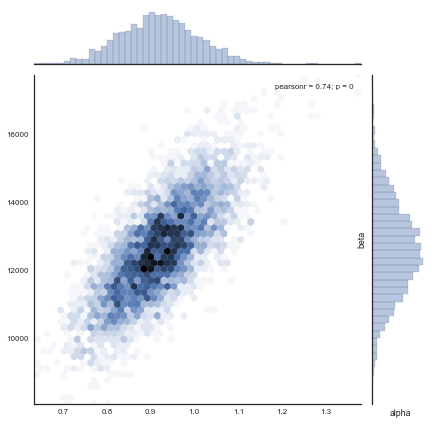

In [14]:
sns.jointplot(result_burn[0,:], result_burn[1,:], kind="hex")
plt.xlabel('alpha')
plt.ylabel('beta')

**1(d): Posterior Distribution: Marginal Distribution of  $\theta_0$ and $\theta_{98}$**

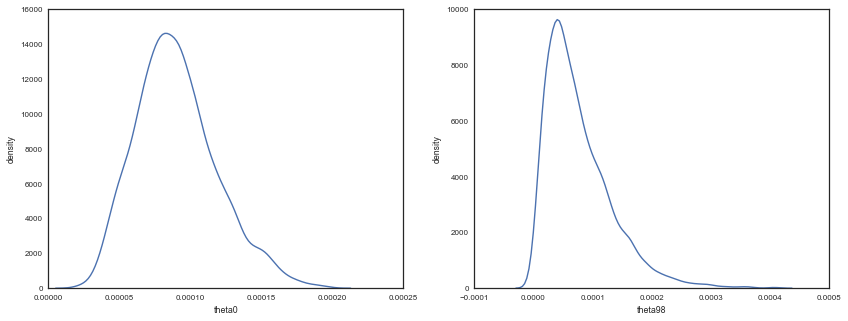

In [15]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.kdeplot(result_burn[2,:])
plt.xlabel('theta0')
plt.ylabel('density')
plt.subplot(1,2,2)
sns.kdeplot(result_burn[100,:])
plt.xlabel('theta98')
plt.ylabel('density')

**1(d): Convergence Diagnosis**

Trace Plots and autocorrelation plots are shown below

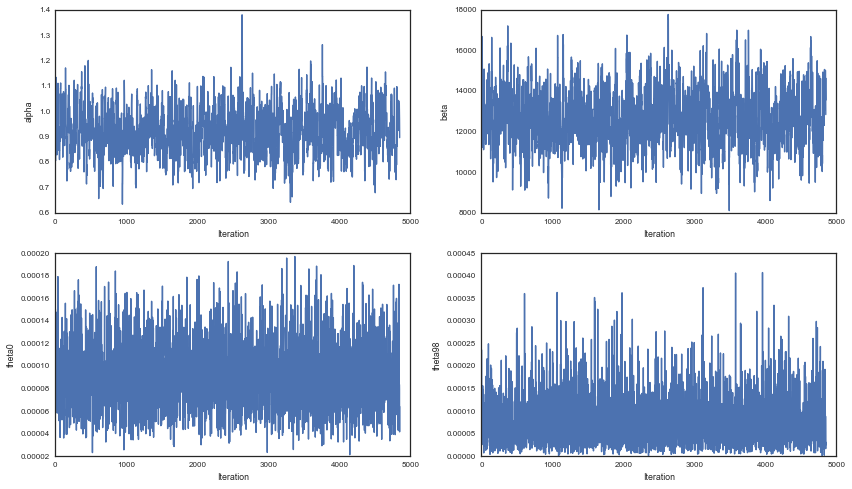

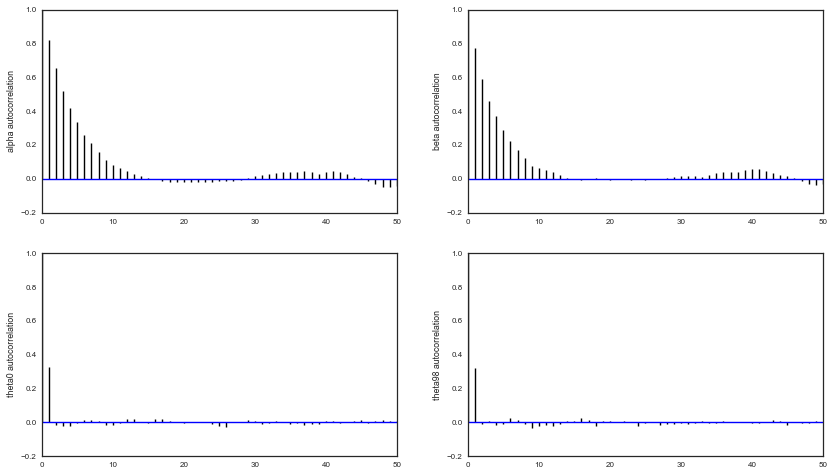

In [16]:
#posterior convergence
#trace plot
plt.figure(figsize=(14,8))
plt.subplot(2,2,1) 
plt.plot(range(len(result_burn[0,:])), result_burn[0,:])
plt.xlabel('Iteration')
plt.ylabel('alpha')
plt.subplot(2,2,2)
plt.plot(range(len(result_burn[1,:])), result_burn[1,:])
plt.xlabel('Iteration')
plt.ylabel('beta')
plt.subplot(2,2,3)
plt.plot(range(len(result_burn[2,:])), result_burn[2,:])
plt.xlabel('Iteration')
plt.ylabel('theta0')
plt.subplot(2,2,4)
plt.plot(range(len(result_burn[100,:])), result_burn[100,:])
plt.xlabel('Iteration')
plt.ylabel('theta98')

#autocorrelation plot
plt.figure(figsize=(14,8))
plt.subplot(2,2,1) 
plt.acorr(result_burn[0,]-np.mean(result_burn[0,]), maxlags=50)
plt.xlim(0,50)
plt.ylabel('alpha autocorrelation')
plt.subplot(2,2,2)
plt.acorr(result_burn[1,]-np.mean(result_burn[1,]), maxlags=50)
plt.xlim(0,50)
plt.ylabel('beta autocorrelation')
plt.subplot(2,2,3)
plt.acorr(result_burn[2,]-np.mean(result_burn[2,]), maxlags=50)
plt.xlim(0,50)
plt.ylabel('theta0 autocorrelation')
plt.subplot(2,2,4)
plt.acorr(result_burn[100,]-np.mean(result_burn[100,]), maxlags=50)
plt.xlim(0,50)
plt.ylabel('theta98 autocorrelation')

**1(d): Effect of Regularizer**

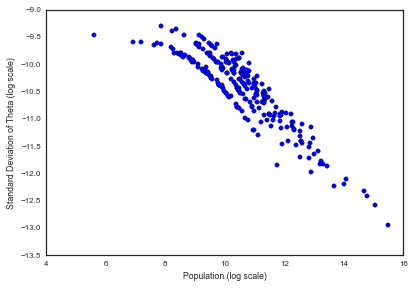

In [17]:
plt.scatter(np.log(pop), np.log(np.std(result_burn[2:, ], axis=1)))
plt.ylabel('Standard Deviation of Theta (log scale)')
plt.xlabel('Population (log scale)')

From the plot above, it can be seen that the Bayesian model has the regularizer effects. Counties with smaller population tend to have higher estimation variance, so their vanriance is more close to the variance of the prior distribution.

With the Gibbs sampler, we are not restricted to the conjugate prior. We may use the distribution of death rates in the data as the prior distribution of the death rate.